# Xây dựng hệ thống gợi ý sản phẩm cho người tiêu dùng dựa trên mô hình học sâu

## 1. Thư viện

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt 

from tqdm.notebook import tqdm 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')

## 2. Phân tích khai phá và xử lý dữ liệu

In [39]:
df = pd.read_csv('/kaggle/input/test-model-neumf/online_retail_II.csv',
                 parse_dates=['InvoiceDate'],
                 dtype={'Customer ID':'object'})

# df = pd.read_csv(r'C:\Users\user\Documents\python\Project KDTM\online_retail_II.csv',
#                  parse_dates=['InvoiceDate'],
#                  dtype={'Customer ID':'float'})

In [40]:
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
396030,527383,85066,CREAM SWEETHEART MINI CHEST,2,2010-10-17 13:01:00,12.75,14839.0,United Kingdom
259698,514480,84313B,BLUE TV TRAY TABLE,1,2010-07-02 14:15:00,4.25,16409.0,United Kingdom
1039854,579694,21731,RED TOADSTOOL LED NIGHT LIGHT,5,2011-11-30 14:11:00,4.13,NaN,United Kingdom
877191,567668,22988,SOLDIERS EGG CUP,2,2011-09-21 15:29:00,2.46,NaN,United Kingdom
579226,540848,22476,EMPIRE UNION JACK TV DINNER TRAY,1,2011-01-12 09:26:00,11.02,NaN,United Kingdom


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [42]:
# chuyển đổi kiểu dữ liệu và tạo thêm cột mới
df['Total'] = df['Quantity']*df['Price']
df['Invoice_Year'] = df['InvoiceDate'].dt.year
df['Invoice_Month'] = df['InvoiceDate'].dt.month
df['Invoice_Day'] = df['InvoiceDate'].dt.day
df['Invoice_Time'] = df['InvoiceDate'].dt.time
df['Invoice_Hour'] = df['InvoiceDate'].dt.hour
df['Invoice_Quarter'] = df['Invoice_Month'].apply(lambda x: (x-1)//3 + 1)
df['Country'] = df['Country'].astype("category")

In [43]:
# Kiểm tra xem có bao nhiêu giá trị NaN
df.isna().sum()

Invoice                 0
StockCode               0
Description          4382
Quantity                0
InvoiceDate             0
Price                   0
Customer ID        243007
Country                 0
Total                   0
Invoice_Year            0
Invoice_Month           0
Invoice_Day             0
Invoice_Time            0
Invoice_Hour            0
Invoice_Quarter         0
dtype: int64

- Cột Description có 4382 giá trị NaN
- Cột Customer ID có 243007 giá trị Nan. Một số lượng NaN đáng kể trong dữ liệu.

Tiếp tục khám phá những cột này để tìm câu trả lời tại sao lại có nhiều Nan đến vậy 

In [44]:
# Trước tiên là cột Description
description_nan = df[df['Description'].isna()]
description_nan

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_Time,Invoice_Hour,Invoice_Quarter
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom,-0.0,2009,12,1,11:44:00,11,4
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom,-0.0,2009,12,1,17:26:00,17,4
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom,0.0,2009,12,1,17:39:00,17,4
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom,0.0,2009,12,2,11:45:00,11,4
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom,-0.0,2009,12,2,12:42:00,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060783,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom,-0.0,2011,12,7,18:26:00,18,4
1060787,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom,0.0,2011,12,7,18:31:00,18,4
1060793,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom,0.0,2011,12,7,18:35:00,18,4
1062442,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,0.0,2011,12,8,10:33:00,10,4


In [45]:
description_nan[(description_nan['Price'] == 0.0) & (description_nan['Customer ID'].isna())]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_Time,Invoice_Hour,Invoice_Quarter
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom,-0.0,2009,12,1,11:44:00,11,4
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom,-0.0,2009,12,1,17:26:00,17,4
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom,0.0,2009,12,1,17:39:00,17,4
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom,0.0,2009,12,2,11:45:00,11,4
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom,-0.0,2009,12,2,12:42:00,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060783,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom,-0.0,2011,12,7,18:26:00,18,4
1060787,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom,0.0,2011,12,7,18:31:00,18,4
1060793,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom,0.0,2011,12,7,18:35:00,18,4
1062442,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom,0.0,2011,12,8,10:33:00,10,4


- Ta thấy rằng, tất cả dữ liệu không có description thì giá đều bằng 0 và cũng không có customer id
- Có thể kết luận khả năng cao những đơn hàng đó bị hủy và giá bằng 0  cho thấy không có doanh thu từ những đơn này. Những giá trị NaN có thể là do khách hàng hủy đơn. Vì vậy, quyết định loại bỏ những giá trị NaN khỏi bộ dữ liệu

In [46]:
df = df[df['Description'].notna()]

Tuy nhiên sau khi kiểm tra lại lần cuối thì phát hiện ra có một số dữ liệu được dùng cho kiểm thử. Bây giờ sẽ xác định dữ liệu và customer id kiểm thử để loại bỏ chúng

In [47]:
df[df['Description'].str.contains('test')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_Time,Invoice_Hour,Invoice_Quarter
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.5,12346.0,United Kingdom,45.0,2009,12,14,08:34:00,8,4
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.5,12346.0,United Kingdom,22.5,2009,12,14,11:00:00,11,4
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.5,12346.0,United Kingdom,22.5,2009,12,14,11:02:00,11,4
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.5,12346.0,United Kingdom,22.5,2009,12,18,10:47:00,10,4
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.0,12346.0,United Kingdom,1.0,2009,12,18,10:55:00,10,4
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.5,12346.0,United Kingdom,22.5,2010,1,4,09:24:00,9,1
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.5,12346.0,United Kingdom,22.5,2010,1,4,09:53:00,9,1
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.5,12346.0,United Kingdom,22.5,2010,1,14,13:50:00,13,1
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.5,12346.0,United Kingdom,22.5,2010,1,22,13:30:00,13,1
89084,497819,TEST001,This is a test product.,5,2010-02-12 14:58:00,0.0,14103.0,United Kingdom,0.0,2010,2,12,14:58:00,14,1


In [48]:
test_customer_ids = df[df['Description'].str.contains('test')]['Customer ID'].unique()
test_customer_ids

array([12346., 14103., 14827., 16454., 16446.,    nan])

In [49]:
# loại bỏ giá trị nan trong test_customer_ids
test_customer_ids = test_customer_ids[~np.isnan(test_customer_ids)]
test_customer_ids

array([12346., 14103., 14827., 16454., 16446.])

In [50]:
# loại bỏ dữ liệu kiểm thử
df = df[~df['Customer ID'].isin(test_customer_ids)]

In [51]:
# cột Customer ID
customerid_nan = df[df['Customer ID'].isna()]
customerid_nan

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_Time,Invoice_Hour,Invoice_Quarter
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,0.55,2009,12,1,11:49:00,11,4
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,0.85,2009,12,1,11:49:00,11,4
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2.95,2009,12,1,12:32:00,12,4
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom,15.00,2009,12,1,12:32:00,12,4
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom,8.85,2009,12,1,12:32:00,12,4
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom,1.65,2009,12,1,12:32:00,12,4
1059,489548,22131,FOOD CONTAINER SET 3 LOVE HEART,2,2009-12-01 12:32:00,1.95,NaN,United Kingdom,3.90,2009,12,1,12:32:00,12,4


- Quan sát dữ liệu ta thấy, những customer id nan thì có phát sinh doanh thu và không có doanh thu. Vì thế có thể kết luận rằng, khách hàng có thể không cần đăng nhập tài khoản vẫn có thể mua hàng được. Nên quyết định không loại bỏ những nan này

In [52]:
# kiểm tra xem có dữ liệu bị trùng lặp không
duplicated = df[df.duplicated(keep=False)].sort_values(by=['InvoiceDate', 'Invoice', 'StockCode'])
duplicated

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_Time,Invoice_Hour,Invoice_Quarter
379,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom,1.95,2009,12,1,11:34:00,11,4
391,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom,1.95,2009,12,1,11:34:00,11,4
365,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom,3.75,2009,12,1,11:34:00,11,4
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom,3.75,2009,12,1,11:34:00,11,4
363,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom,3.75,2009,12,1,11:34:00,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067116,581538,23275,SET OF 3 HANGING OWLS OLLIE BEAK,1,2011-12-09 11:34:00,1.25,14446.0,United Kingdom,1.25,2011,12,9,11:34:00,11,4
1067117,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom,2.49,2011,12,9,11:34:00,11,4
1067150,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom,2.49,2011,12,9,11:34:00,11,4
1067127,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,1,2011-12-09 11:34:00,2.08,14446.0,United Kingdom,2.08,2011,12,9,11:34:00,11,4


Sau khi quan sát kĩ các hàng trùng lặp thì thấy rằng các mặt hàng trùng lặp thường được liệt kê trên cùng một hóa đơn. Có thể đã xảy ra lỗi kỹ thuật khiến hệ thống không thể cập nhật số lượng chính xác và thay vào đó tạo các đơn hàng riêng biệt cho từng mặt hàng đã mua. Vì vậy quyết định không loại bỏ dòng trùng lặp khỏi dữ liệu vì chúng có thể quan trọng để hiểu cách khách hàng mua nhiều mặt hàng cùng nhau và xác định bức tranh chính xác hơn về hành vi mua hàng

In [53]:
month_counts = duplicated[['Invoice_Year', 'Invoice_Month']].value_counts().sort_index() 
month_counts

Invoice_Year  Invoice_Month
2009          12                 977
2010          1                  628
              2                  631
              3                 1014
              4                  801
              5                  814
              6                 1002
              7                  766
              8                  708
              9                  940
              10                1636
              11                2747
              12               45167
2011          1                  475
              2                  445
              3                  593
              4                  415
              5                  484
              6                  487
              7                  495
              8                  433
              9                  707
              10                1482
              11                2641
              12                 538
Name: count, dtype: int64

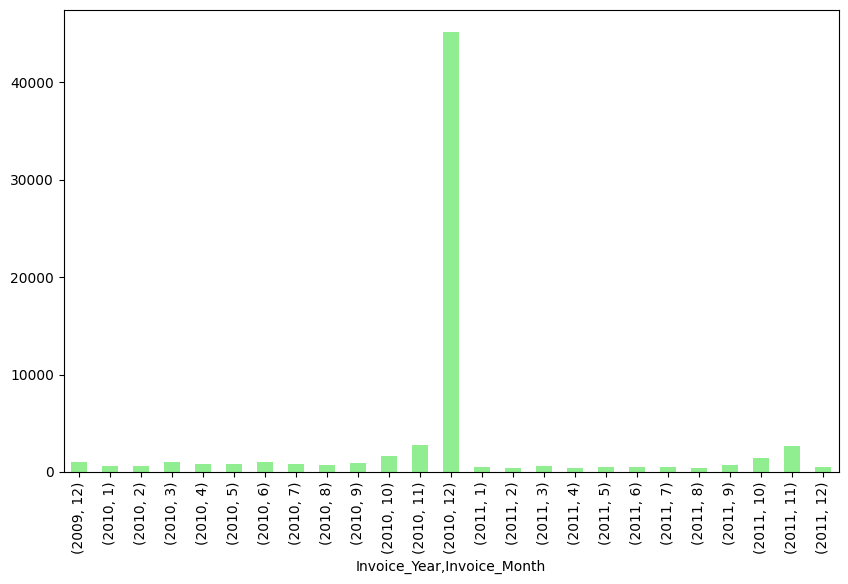

In [54]:
month_counts.plot(kind='bar', color='lightgreen', figsize=(10, 6));

Quan sát biểu đồ cột cho thấy sự tăng đột biến về số dòng trùng lặp trong tháng 12/2010 với khoảng 45000 trùng lặp. Điều này có thể có nghĩa là đã xảy ra sự cố với hệ thống thu thập hoặc xử lý dữ liệu trong tháng đó

In [55]:
# những đơn hàng bị hủy
cancalled_orders = df[df['Invoice'].str.startswith('C', na=False)]
cancalled_orders

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day,Invoice_Time,Invoice_Hour,Invoice_Quarter
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.40,2009,12,1,10:33:00,10,4
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,-9.90,2009,12,1,10:33:00,10,4
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,-17.00,2009,12,1,10:33:00,10,4
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,-12.60,2009,12,1,10:33:00,10,4
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.40,2009,12,1,10:33:00,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13,2011,12,9,09:57:00,9,4
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69,2011,12,9,10:28:00,10,4
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75,2011,12,9,11:57:00,11,4
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25,2011,12,9,11:58:00,11,4


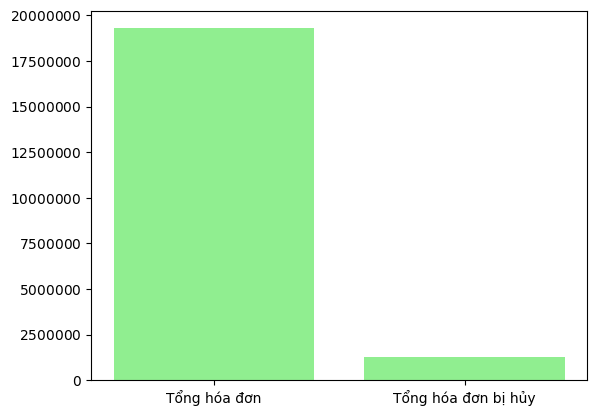

In [56]:
# tỷ lệ tổng hóa đơn trên tổng hóa đơn bị hủy
total_invoice = df['Total'].sum()
total_cancelled = cancalled_orders['Total'].sum() * (-1)

plt.bar(['Tổng hóa đơn', 'Tổng hóa đơn bị hủy'], [total_invoice, total_cancelled], color='lightgreen')
plt.ticklabel_format(style='plain', axis='y',useMathText=True)
plt.show()

### Phân tích sản phẩm

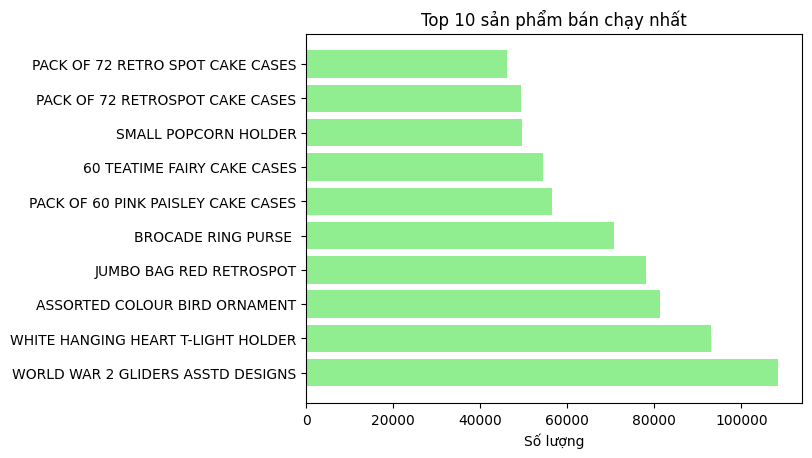

In [57]:
total_by_quantity = df.groupby(['Description'])['Quantity'].sum().sort_values(ascending=False)

plt.barh(total_by_quantity.nlargest(10).index, total_by_quantity.nlargest(10).values, color='lightgreen')
plt.title('Top 10 sản phẩm bán chạy nhất')
plt.xlabel('Số lượng')
plt.show()

- Ta thấy rằng sản phẩm Tàu lượn thế chiến II là sản phẩm bán chạy nhất với hơn 100000 chiếc. Tuy nhiên, các sản phẩm tiện dụng cũng bán khá chạy. Các sp lọt top đều có điểm chung là dùng để phục vụ kinh doanh( vỏ đựng bánh, đồ ăn, đồ tặng kèm, trong đó mô hình máy bay này từng rất phổ biến trong việc là quà tặng kèm khi mua sản phẩm)
- Có thể thấy top 10 đều là sản phẩm có thể gọi chung là hàng tiêu dùng hoặc hàng tiện dụng. Đây đều là sản phẩm được mua thường xuyên trong thời gian ngắn và không có giá trị lâu dài. Chúng thuộc danh mục FMCG vì chúng được tiêu thụ nhanh chóng và có nhu cầu mua lại cao


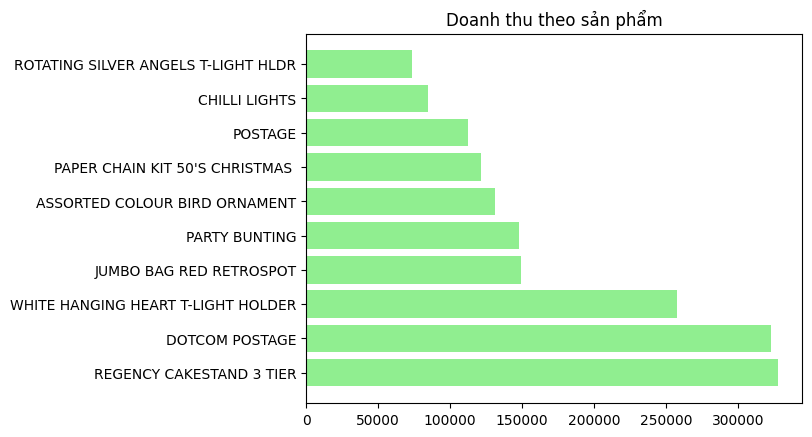

In [58]:
total_by_item = df.groupby(['Description'])['Total'].sum().sort_values(ascending=False)

plt.barh(total_by_item.nlargest(10).index, total_by_item.nlargest(10).values, color='lightgreen')
plt.title('Doanh thu theo sản phẩm')
plt.show()

Qua 2 biểu đồ ta thấy rằng mặc dù Tàu lượn thế chiến II là sản phẩm bán chạy nhất nhưng lại không nằm trong top 10 sản phẩm có doanh thu cao nhất. Tuy nhiên sản phẩm bán chạy thứ 2 nằm trong top 3 sản phẩm doanh thu cao nhất

### Doanh thu theo quốc gia

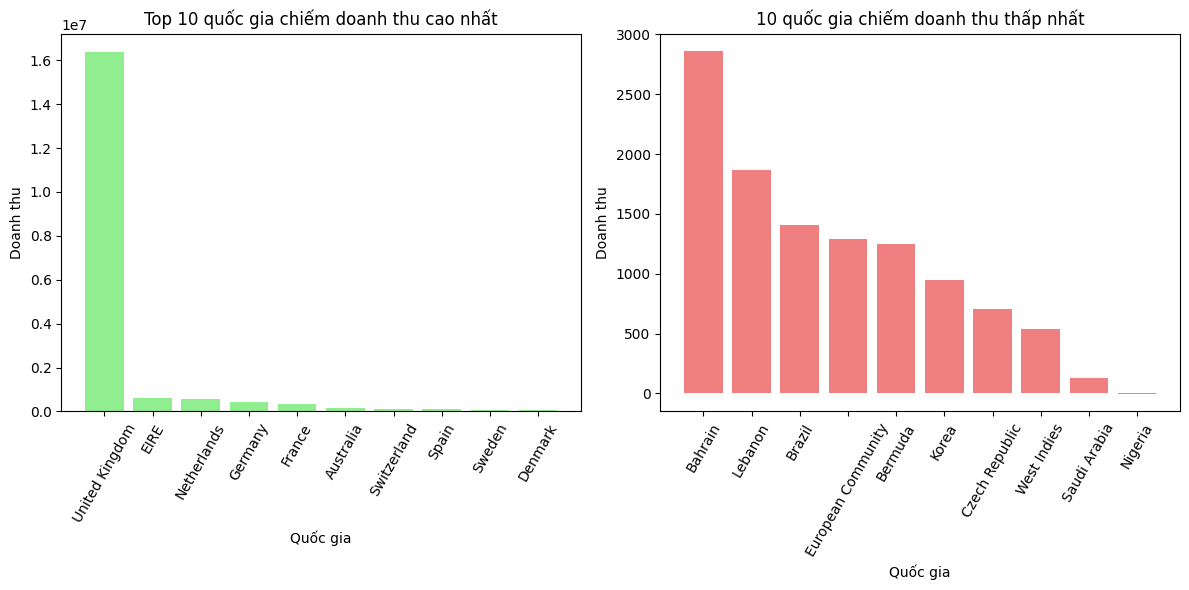

In [59]:
country_totals = df.groupby(['Country'])['Total'].sum().sort_values(ascending=False)
country_totals_top10 = country_totals.head(10)
country_totals_last10 = country_totals.tail(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(country_totals_top10.index, country_totals_top10.values, color='lightgreen')
ax1.set_title('Top 10 quốc gia chiếm doanh thu cao nhất')
ax1.set_xlabel('Quốc gia')
ax1.set_ylabel('Doanh thu') 
ax1.tick_params(axis='x', rotation=60) 

ax2.bar(country_totals_last10.index, country_totals_last10.values, color='lightcoral')
ax2.set_title('10 quốc gia chiếm doanh thu thấp nhất')
ax2.set_xlabel('Quốc gia')
ax2.set_ylabel('Doanh thu')
ax2.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

- Nhìn vào top 10 quốc gia có doanh thu cao nhất, Anh là quốc gia dẫn đầu với tổng lượng mua áp đảo và gấp khoảng 20 lần top 2 là EIRE. Top 10 quốc gia này đều nằm ở Châu Âu
- Nhìn vào top 10 quốc gia có doanh thu thấp nhất, khách hàng từ Ả Rập Xê Út chỉ chi 131$ cho công ty trong 2 năm. Nói chung các quốc gia này đều không thuộc châu Âu, nhưng có 1 ngoại lệ là Cộng Hòa Séc. 

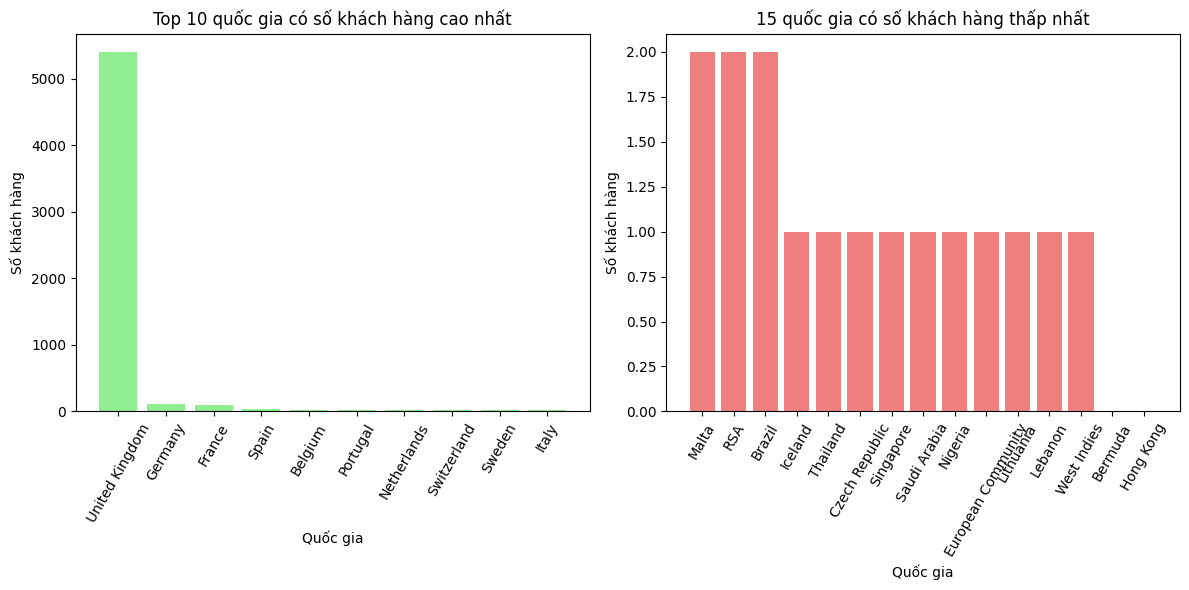

In [60]:
customer_per_country = df.groupby(['Country'])['Customer ID'].nunique().sort_values(ascending=False)
customer_per_country_top10 = customer_per_country.head(10)
customer_per_country_last15 = customer_per_country.tail(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(customer_per_country_top10.index, customer_per_country_top10.values, color='lightgreen')
ax1.set_title('Top 10 quốc gia có số khách hàng cao nhất')
ax1.set_xlabel('Quốc gia')
ax1.set_ylabel('Số khách hàng') 
ax1.tick_params(axis='x', rotation=60) 

ax2.bar(customer_per_country_last15.index, customer_per_country_last15.values, color='lightcoral')
ax2.set_title('15 quốc gia có số khách hàng thấp nhất')
ax2.set_xlabel('Quốc gia')
ax2.set_ylabel('Số khách hàng')
ax2.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

- Anh có khoảng 5400 khách hàng trong khi Đức và Pháp chỉ có 107 và 95 khách hàng. Sự khác biệt này cho thấy Anh thì thị trường chính của công ty
- Ngoài ra có nhiều quốc gia chỉ có 1 khách hàng như Thái Lan, Nigeria... Và Cộng Hòa Séc một lần nữa là một ngoại lệ trong danh sách này

### Doanh thu theo thời gian

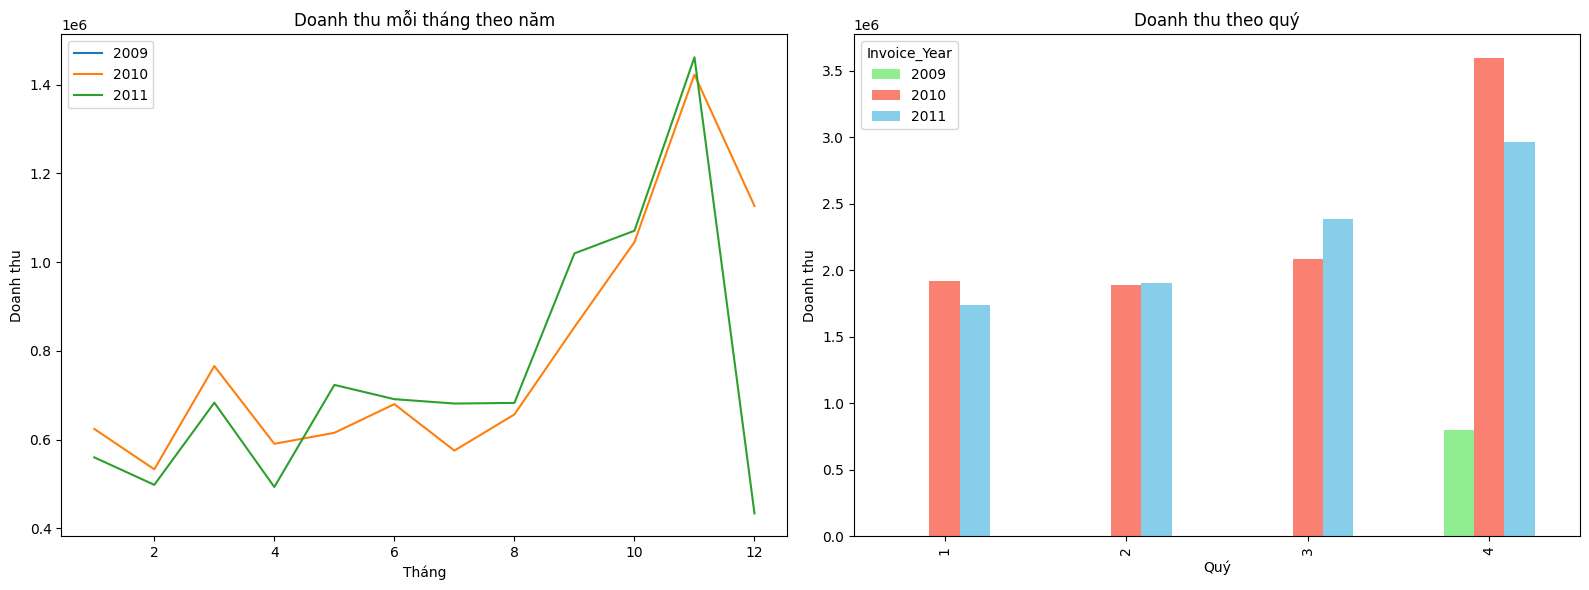

In [61]:
monthly_sales = df.groupby(['Invoice_Year', 'Invoice_Month'])['Total'].sum()
quarterly_sales = df.groupby(['Invoice_Year', 'Invoice_Quarter'])['Total'].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for year in monthly_sales.index.get_level_values('Invoice_Year').unique():
    monthly_sales_year = monthly_sales.loc[year]
    ax1.plot(monthly_sales_year.index, monthly_sales_year.values, label=str(year))
ax1.set_xlabel('Tháng')
ax1.set_ylabel('Doanh thu')
ax1.set_title('Doanh thu mỗi tháng theo năm')
ax1.legend()

quarterly_sales.unstack(level='Invoice_Year').plot(kind='bar', ax=ax2, color=['lightgreen', 'salmon', 'skyblue'])
ax2.set_xlabel('Quý')
ax2.set_ylabel('Doanh thu')
ax2.set_title('Doanh thu theo quý')

plt.tight_layout()
plt.show()

- Doanh thu tháng 2 và tháng 4 lần lượt giảm vào năm 2010 và 2011, nguyên nhân có thể là do hành vi giảm của khách hàng đối với một số sản phẩm nhất định, cũng có thể do hoạt động tiếp thị và khuyến mãi có nghĩa là nếu công ty thực hiện các chiến dịch tiếp thị hoặc khuyến mãi lớn trong những tháng củ thể thì doanh thu có thể thấp hơn so với tháng trước đó. Hoạt động khuyến mãi giảm trong tháng 2 và tháng 4 có thể dẫn đến doanh thu thấp hơn
- Vào những tháng cuối năm, khách hàng bắt đầu mua nhiều hơn để chuẩn bị cho các sự kiện cuối năm như giáng sinh, năm mới

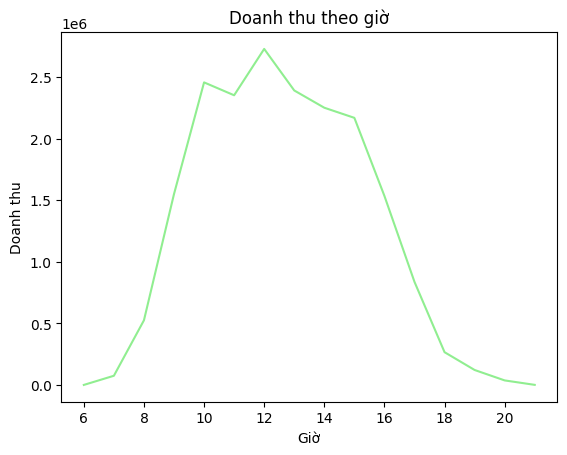

In [62]:
sales_hours = df.groupby('Invoice_Hour')['Total'].sum().reset_index()

plt.plot(sales_hours['Invoice_Hour'], sales_hours['Total'], color='lightgreen')
plt.title('Doanh thu theo giờ')
plt.xlabel('Giờ')
plt.ylabel('Doanh thu')
plt.show()

Từ biểu đồ này ta thấy doanh thu chủ yếu rơi vào khoảng thời gian từ 10h đến 13h và cao nhất là vào 12h. Đây là khung giờ vàng để công ty nên tập trung và tối ưu hóa hoạt động bán hàng hoặc tiếp thị trong những giờ có doanh thu cao này

### Phân tích theo khách hàng

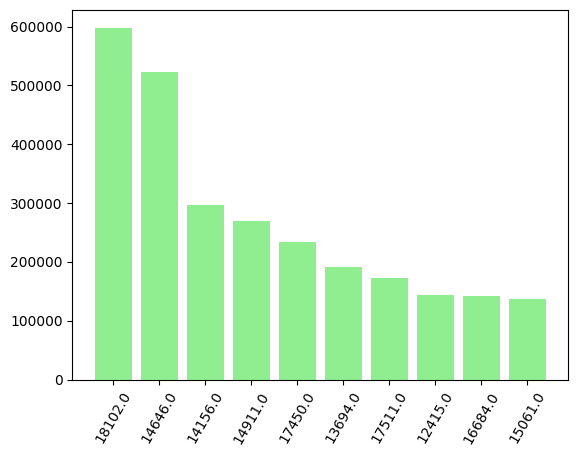

In [63]:
top_customers = df.groupby(['Customer ID'])['Total'].sum().sort_values(ascending=False).reset_index()
top_10_customer = top_customers.head(10)

plt.bar(top_10_customer['Customer ID'].astype(str), top_10_customer['Total'], color='lightgreen')
plt.xticks(rotation=60)
plt.show()

Khách hàng có ID là 18102 đã chi nhiều tiền nhất cho công ty. Khách hàng này đến từ Anh và đã trả tổng cộng 598000$. Khách hàng thứ 2 có ID là 14646 đến từ Hà Lan với 523000$. Nhìn chung thì top 10 khách hàng đến từ Anh, EIRE, Hà Lan và Úc đều là các quốc gia có nền kinh tế phát triển  

Tỷ lệ khách hàng chỉ mua hàng một lần: 24.57%


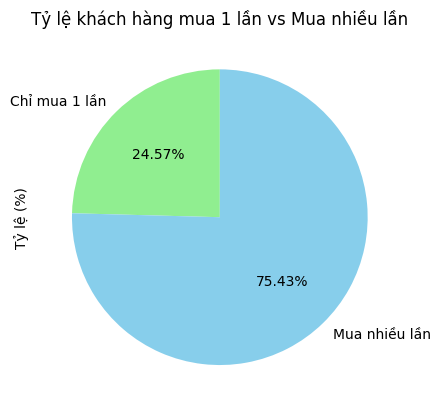

In [69]:
data = df.dropna(subset=['Customer ID'])
customer_purchases = data.groupby('Customer ID')['Invoice'].nunique()
one_time_customers = customer_purchases[customer_purchases == 1].count()
multi_time_customers = customer_purchases[customer_purchases > 1].count()
total_customers = customer_purchases.count()

one_time_ratio = (one_time_customers / total_customers) * 100
multi_time_ratio = (multi_time_customers / total_customers) * 100
print(f"Tỷ lệ khách hàng chỉ mua hàng một lần: {one_time_ratio:.2f}%")

plt.pie([one_time_ratio, multi_time_ratio],
    labels=['Chỉ mua 1 lần', 'Mua nhiều lần'],
    colors=['lightgreen', 'skyblue'],
    autopct='%1.2f%%',
    startangle=90
)

plt.title('Tỷ lệ khách hàng mua 1 lần vs Mua nhiều lần')
plt.ylabel('Tỷ lệ (%)')
plt.show()

In [70]:
customer_revenue = data.groupby('Customer ID')['Total'].sum()
customer_revenue = customer_revenue.sort_values(ascending=False)
cumulative_revenue = customer_revenue.cumsum() / customer_revenue.sum()
top_80_percent_customers = cumulative_revenue[cumulative_revenue <= 0.8].count()

top_20_percent_ratio = (top_80_percent_customers / total_customers) * 100
print(f"Tỷ lệ khách hàng đóng góp 80% doanh thu: {top_20_percent_ratio:.2f}%")

Tỷ lệ khách hàng đóng góp 80% doanh thu: 22.74%


- Từ 2 kết quả trên, nhận thấy rằng 24.75% khách hàng chỉ mua một lần, đây là nhóm khách hàng tièm năng có thể được tiếp cận lại thông qua các chiến lược tiếp thị hoặc gợi ý sản phẩm để tăng tần suất mua sắm của họ
- Đồng thời, 80% doanh thu được đóng góp bỏi chỉ 22.74% khách hàng, kết quả này gần với nguyên tắc Pareto(80/20), cho thấy 22.74% khách hàng có vai trò quan trọng và là nguồn đóng góp chính cho doanh thu của công ty

Dựa trên những kết quả này, nhóm quyết định xây dựng hệ thống gợi ý cho người tiêu dùng với mô hình NeuMF, không chỉ nhằm tăng sự hài lòng của khách hàng hiện tại mà còn để khuyến khích khách hàng mua sắm nhiều hơn. Điều này sẽ giúp tối ưu hóa doanh thu và nâng cao trải nghiệm khách hàng.

## 3. Xây dựng hệ thống gợi ý NeuMF

In [71]:
df = df.dropna()
df = df.drop(df[df['Quantity'] < 0].index)

In [72]:
df = df.drop(df[((df["StockCode"].str.len()>7) | (df["StockCode"].str.len()<5))].index)
df["StockCode"] = df["StockCode"].apply(lambda x: x[:5])
df = df.drop(df[df["StockCode"].str.contains(r"[A-Za-z]")].index)

In [73]:
df = df[['Customer ID', 'StockCode', 'Quantity', 'InvoiceDate']]

In [74]:
num_users = df['Customer ID'].nunique()
num_items = df['StockCode'].nunique()
sparsity = 1 - len(df) / (num_items * num_users)

print(f'Số khách hàng: {num_users}, Số sản phẩm: {num_items}')
print(f'Ma trận thưa: {sparsity:f}')

Số khách hàng: 5850, Số sản phẩm: 3862
Ma trận thưa: 0.964472


In [75]:
# Nhóm và tính tổng số lượng sản phẩm khách hàng đã mua
grouped_df = df.groupby(['Customer ID', 'StockCode', 'InvoiceDate'], as_index=False)['Quantity'].sum()

In [76]:
# Đổi tên cột
grouped_df = grouped_df.rename(columns={'Customer ID': 'user_id',
                                        'StockCode': 'item_id',
                                        'Quantity': 'purchase', 
                                        'InvoiceDate':'timestamp'})

In [77]:
new_df = grouped_df[['user_id', 'item_id', 'purchase', 'timestamp']]

In [78]:
# Loại bỏ những khách hàng có dưới 10 tương tác
user_counts = new_df['user_id'].value_counts()

transaction_users = user_counts[user_counts > 9].index
# transaction_users = user_counts[(user_counts > 19) & (user_counts < 3500)].index
filter_df = new_df[new_df['user_id'].isin(transaction_users)]
new_df = filter_df
filter_df

,user_id,item_id,purchase,timestamp
0,12347.0,16008,24,2011-04-07 10:43:00
1,12347.0,17021,36,2011-06-09 13:01:00
2,12347.0,20665,6,2011-04-07 10:43:00
3,12347.0,20712,10,2010-10-31 14:20:00
4,12347.0,20716,10,2010-10-31 14:20:00
...,...,...,...,...
745717,18287.0,85040,48,2011-05-22 10:39:00
745718,18287.0,85041,12,2010-05-17 11:55:00
745719,18287.0,85173,48,2011-10-12 10:23:00
745720,18287.0,85199,24,2010-05-17 11:55:00


In [79]:
# chuyển đổi kiểu dữ liệu sang dạng số 
new_df[['user_id', 'item_id', 'purchase']] = new_df[['user_id', 'item_id', 'purchase']].astype(float).astype(int)

In [80]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 742352 entries, 0 to 745721
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    742352 non-null  int32         
 1   item_id    742352 non-null  int32         
 2   purchase   742352 non-null  int32         
 3   timestamp  742352 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 19.8 MB


In [81]:
# Lọc ra 1 sản phẩm gần nhất mà mỗi khách hàng đã mua
new_df['rank_lastest'] = new_df.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
new_df['purchase'] = new_df['purchase'].apply(lambda x: 1 if x>0 else 0)
new_df[new_df['rank_lastest'] == 1]

,user_id,item_id,purchase,timestamp,rank_lastest
9,12347,20719,1,2011-12-07 15:52:00,1.0
246,12348,23077,1,2011-09-25 13:13:00,1.0
260,12349,20685,1,2011-11-21 09:51:00,1.0
426,12350,20615,1,2011-02-02 16:01:00,1.0
442,12351,20886,1,2010-11-29 15:23:00,1.0
...,...,...,...,...,...
744595,18283,20712,1,2011-12-06 12:02:00,1.0
745476,18284,16237,1,2010-10-04 11:33:00,1.0
745502,18285,20802,1,2010-02-17 10:24:00,1.0
745513,18286,10135,1,2010-08-20 11:57:00,1.0


In [82]:
# Chia tập train và tập test
train_df = new_df[new_df['rank_lastest'] != 1]
test_df = new_df[new_df['rank_lastest'] == 1]

train_df = train_df[['user_id', 'item_id', 'purchase']]
test_df = test_df[['user_id', 'item_id', 'purchase']]

In [83]:
class RetailTrainDataSet(Dataset):
    def __init__(self, df, all_itemIds):
        self.users, self.items, self.labels = self.get_dataset(df, all_itemIds)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, df, all_itemIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(df['user_id'], df['item_id']))
        num_negative = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negative):
                negative_item = np.random.choice(all_itemIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_itemIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)
        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

### Mô hình GMF

In [85]:
class GMF(pl.LightningModule):
    def __init__(self, factor_num, num_users, num_items, df, all_itemIds, learning_rate, batch_size):
        super().__init__()

        # Khởi tạo các tham số
        self.num_users = num_users 
        self.num_items = num_items
        self.factor_num = factor_num 

        # lớp nhúng
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        # lớp đầu ra
        self.output_layer = nn.Linear(in_features=self.factor_num, out_features=1)

        # Các tham số khác
        self.df = df 
        self.all_itemIds = all_itemIds
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Gọi hàm khởi tạo trọng số
        self.init_weight()

        # Để lưu loss sau mỗi epoch
        self.train_losses = []
    # khởi tạo trọng số và bias
    def init_weight(self):
        nn.init.normal_(self.embedding_user.weight, std=0.01)
        nn.init.normal_(self.embedding_item.weight, std=0.01)
        nn.init.xavier_uniform_(self.output_layer.weight)

        if self.output_layer.bias is not None:
            nn.init.zeros_(self.output_layer.bias)
    # hàm forward để tính dự đoán
    def forward(self, user_input, item_input):
        """Dự đoán đầu ra."""
        user_embedding = self.embedding_user(user_input)  # Embedding vector cho user
        item_embedding = self.embedding_item(item_input)  # Embedding vector cho item

        # Tích Hadamard giữa embedding user và item
        element_product = torch.mul(user_embedding, item_embedding)

        # Dự đoán thông qua lớp fully connected
        output = self.output_layer(element_product)
        return torch.sigmoid(output)  # Trả về xác suất
    # hàm thực hiện các bước huấn luyện trên batch
    def training_step(self, batch, batch_idx):
        """Một bước huấn luyện."""
        user_input, item_input, labels = batch 
        pred_labels = self(user_input, item_input)
        loss = nn.BCELoss()(pred_labels, labels.view(-1, 1).float())
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss 
    # lưu giá trị trung bình của train loss trong epoch
    def on_train_epoch_end(self):
        """Lưu giá trị loss sau mỗi epoch."""
        avg_loss = self.trainer.callback_metrics.get("train_loss", torch.tensor(0.0)).item()
        self.train_losses.append(avg_loss)
    # Sử dụng adam để tối ứu tham số trong quá trình huấn luyện
    def configure_optimizers(self):
        """Cấu hình tối ưu hóa."""
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    # tạo DataLoader để cung cấp batch dữ liệu trong quá trình huấn luyện
    def train_dataloader(self):
        """Chuẩn bị dataloader."""
        return DataLoader(RetailTrainDataSet(self.df, self.all_itemIds), batch_size=self.batch_size, num_workers=4)

### Mô hình MLP

In [86]:
class MLP(pl.LightningModule):
    def __init__(self, factor_num, num_users, num_items, df, all_itemIds, hidden_units, learning_rate, batch_size):
        super().__init__()
        # số lượng khách hàng và sản phẩm
        self.num_users = num_users 
        self.num_items = num_items 
        # số chiều của embedding
        self.factor_num = int(hidden_units[0]/2)
        # các lớp ẩn
        self.layers = hidden_units
        # danh sách các lớp fully connected
        self.fc_layers = nn.ModuleList()
        # embedding cho khách hàng và sản phẩm
        self.user_embedding = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.item_embedding = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)
        # khỏi tạo các lớp fully connected
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_features=in_size, out_features=out_size))
        # lớp đầu ra
        self.output_layer = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()
        self.df = df
        self.all_itemIds = all_itemIds
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_losses = []
        

    def init_weight(self):
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    layer.bias.data.zero_()

        nn.init.xavier_uniform_(self.output_layer.weight)
        if self.output_layer.bias is not None:
            self.output_layer.bias.data.zero_()

    def forward(self, user_input, item_input):
        user_embedding = self.user_embedding(user_input)
        item_embedding = self.item_embedding(item_input)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            vector = nn.Dropout(0.3)(vector)
            # vector = nn.BatchNorm1d()(vector)

        output = self.output_layer(vector)
        pred = self.sigmoid(output)
        return pred
        
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch 
        pred_labels = self(user_input, item_input)
        loss = nn.BCELoss()(pred_labels, labels.view(-1, 1).float())
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss 
    # Lưu giá trị trung bình loss sau mỗi epoch
    def on_train_epoch_end(self):   
        avg_loss = self.trainer.callback_metrics.get("train_loss", torch.tensor(0.0)).item()
        self.train_losses.append(avg_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return DataLoader(RetailTrainDataSet(self.df, self.all_itemIds), batch_size=self.batch_size, num_workers=4)

### Mô hình NeuMF

In [87]:
class NeuMF(pl.LightningModule):
    def __init__(self, factor_num, num_users, num_items, df, all_itemIds, hidden_units, learning_rate, batch_size):
        super().__init__()
        # số lượng khách hàng và sản phẩm
        self.num_users = num_users 
        self.num_items = num_items 
        # số yếu tố ẩn cho MF và MLP
        self.factor_num_mf = factor_num 
        self.factor_num_mlp = int(hidden_units[0]/2)
        # danh sách các lớp ẩn của MLP
        self.layers = hidden_units
        # embedding cho khách hàng và sản phẩm cho MF
        self.embedding_user_mf = nn.Embedding(num_embeddings=num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=num_items, embedding_dim=self.factor_num_mf)
        # embedding cho khách hàng và sản phẩm cho MLP
        self.embedding_user_mlp = nn.Embedding(num_embeddings=num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=num_items, embedding_dim=self.factor_num_mlp)
        # tạo danh sách các lớp fully connected cho MLP
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))
    
        # lớp đầu ra kết hợp MLP và MF
        self.output = nn.Linear(in_features=self.layers[-1] + self.factor_num_mf, out_features=1)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.df = df
        self.all_itemIds = all_itemIds
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_losses = []


    def init_weight(self):
        nn.init.normal_(self.embedding_user_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_user_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mlp.weight, std=0.01)

        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        nn.init.xavier_uniform_(self.output.weight)

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user_input, item_input):
        # tính embedding của khách hàng và sản phẩm cho MF
        user_embedding_mf = self.embedding_user_mf(user_input)
        item_embedding_mf = self.embedding_item_mf(item_input)
        # tính embedding của khách hàng và sản phẩm cho MF
        user_embedding_mlp = self.embedding_user_mlp(user_input)
        item_embedding_mlp = self.embedding_item_mlp(item_input)
        # tích hadamard của MF
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)
        # nối embedding của khách hàng và sản phẩm trong MLP
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = self.relu(mlp_vector)
            mlp_vector = self.dropout(mlp_vector)
        # Kết hợp MLP và MF
        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        output = self.output(vector)
        pred = self.sigmoid(output)
        return pred

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch 
        pred_labels = self(user_input, item_input)
        loss = nn.BCELoss()(pred_labels, labels.view(-1, 1).float())
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss 
    # Lưu giá trị trung bình loss sau mỗi epoch
    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics.get("train_loss", torch.tensor(0.0)).item()
        self.train_losses.append(avg_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return DataLoader(RetailTrainDataSet(self.df, self.all_itemIds), batch_size=self.batch_size, num_workers=4)

In [89]:
num_users = new_df['user_id'].max()+1
num_items = new_df['item_id'].max()+1
all_itemIds = new_df['item_id'].unique()

In [90]:
def evaluate_model(model, df, test_df):
    # chuyển model sang chế độ đánh giá
    model.eval()
    # tạo các cặp khách hàng và sản phẩm trong tập test
    test_user_item_set = set(zip(test_df['user_id'], test_df['item_id']))
    # tạo dict để lưu danh sách các sản phẩm mà mỗi khách hàng đã tương tác
    user_interacted_items = df.groupby('user_id')['item_id'].apply(list).to_dict()
    # danh sách để lưu kết quả HR và NDCG
    hits = []
    ndcgs = []
    # lặp qua từng cặp (khách hàng, sản phẩm)
    for(u,i) in tqdm(test_user_item_set):
        # lấy danh sách các sản phẩm mà khách hàng đã tương tác
        interacted_items = user_interacted_items[u]
        # lấy danh sách các sản phẩm mà khách hàng chưa tương tác
        not_interacted_items = set(all_itemIds) - set(interacted_items)
        # chọn ngẫu nhiên 99 sản phẩm chưa tương tác
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        # tạo danh sách test gồm 99 sản phẩm chưa tương tác và 1 sản phẩm đã tương tác gần nhất
        test_items = selected_not_interacted + [i]
        # dự doán xác suất 100 sản phẩm trong danh sách test
        pred_labels = np.squeeze(model(torch.tensor([u] * 100),
                                         torch.tensor(test_items)).detach().numpy())
        # lấy top 10 sản phẩm có xác suất cao nhất
        top_10_items = [test_items[i] for i in np.argsort(pred_labels)[::-1][0:10].tolist()]
        # kiểm tra xem sản phẩm test có nằm trong top 10 không
        if i in top_10_items:
            hits.append(1)
            rank = top_10_items.index(i) + 1 
            ndcgs.append(1 / np.log2(rank + 1))
        else:
            hits.append(0)
            ndcgs.append(0)
    
    print('The Hits Ratio @ 10 is {:.2f}'.format(np.average(hits)))
    print('The NDCG @ 10 is {:.2f}'.format(np.average(ndcgs)))


### Huấn luyện và đánh giá mô hình

In [173]:
# huấn luyện mô hình GMF
params = [
    (8, 0.0001, 64),
    (16, 0.0005, 128),
    (32, 0.001, 256),
    (64, 0.005, 512)
]
for factor_num, learning_rate, batch_size in params:
    print(f"Training with factor_num = {factor_num}, learning_rate = {learning_rate}, batch_size = {batch_size}")
    
    model_GMF = GMF(factor_num, num_users, num_items, train_df, all_itemIds, learning_rate, batch_size)

    trainer_GMF = pl.Trainer(
        max_epochs=20,
        devices=1,
        reload_dataloaders_every_n_epochs=True,
        enable_progress_bar=True,
        logger=True, 
        callbacks=False
    )
    
    trainer_GMF.fit(model_GMF)

    evaluate_model(model_GMF, new_df, test_df)
    train_losses_GMF = model_GMF.train_losses
    
    print("=" * 20)

Training with factor_num = 8, learning_rate = 0.0001, batch_size = 64


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.45
The NDCG @ 10 is 0.25
Training with factor_num = 16, learning_rate = 0.0005, batch_size = 128


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.64
The NDCG @ 10 is 0.37
Training with factor_num = 32, learning_rate = 0.001, batch_size = 256


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.64
The NDCG @ 10 is 0.37
Training with factor_num = 64, learning_rate = 0.005, batch_size = 512


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.49
The NDCG @ 10 is 0.28


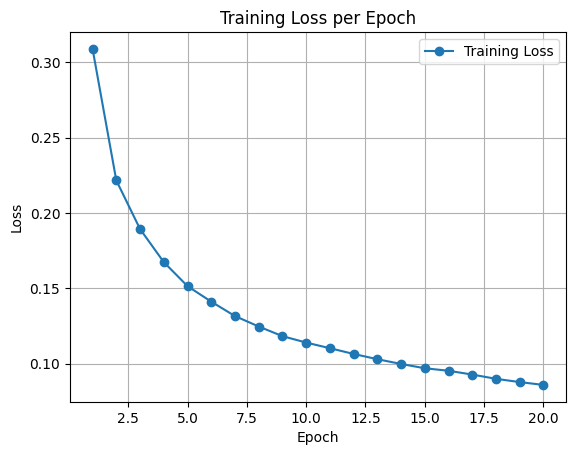

In [174]:
plt.plot(range(1, len(train_losses_GMF) + 1), train_losses_GMF, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

In [175]:
# huấn luyện mô hình MLP
params = [
    (8, 0.0001, 64),
    (16, 0.0005, 128),
    (32, 0.001, 256),
    (64, 0.005, 512)
]
factor_to_hidden_units = {
    8: [16, 8, 4],
    16: [32, 16, 8],
    32: [64, 32, 16],
    64: [128, 64, 32]
}
for factor_num, learning_rate, batch_size in params:
    hidden_units = factor_to_hidden_units[factor_num]
    print(f"Training with factor_num = {factor_num}, learning_rate = {learning_rate}, batch_size = {batch_size}")
    
    model_MLP = MLP(factor_num, num_users, num_items, train_df, all_itemIds, hidden_units, learning_rate, batch_size)

    trainer_MLP = pl.Trainer(
        max_epochs=20,
        devices=1,
        reload_dataloaders_every_n_epochs=True,
        enable_progress_bar=True,
        logger=True,
        callbacks=False
    )
    
    trainer_MLP.fit(model_MLP)

    evaluate_model(model_MLP, new_df, test_df)
    train_losses_MLP = model_MLP.train_losses
    
    print("=" * 20)

Training with factor_num = 8, learning_rate = 0.0001, batch_size = 64


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.49
The NDCG @ 10 is 0.27
Training with factor_num = 16, learning_rate = 0.0005, batch_size = 128


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.61
The NDCG @ 10 is 0.35
Training with factor_num = 32, learning_rate = 0.001, batch_size = 256


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.25
The NDCG @ 10 is 0.15
Training with factor_num = 64, learning_rate = 0.005, batch_size = 512


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.23
The NDCG @ 10 is 0.13


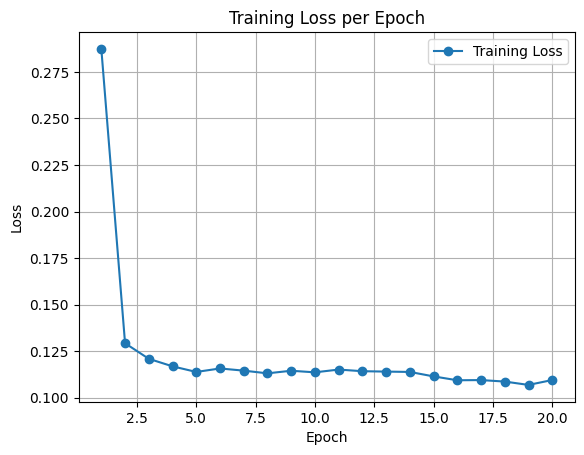

In [176]:
plt.plot(range(1, len(train_losses_MLP) + 1), train_losses_MLP, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

In [179]:
# huấn luyện mô hình NeuMF
params = [
    (8, 0.0001, 64),
    (16, 0.0005, 128),
    (32, 0.001, 256),
    (64, 0.005, 512)
]
factor_to_hidden_units = {
    8: [16, 8, 4],
    16: [32, 16, 8],
    32: [64, 32, 16],
    64: [128, 64, 32]
}
for factor_num, learning_rate, batch_size in params:
    hidden_units = factor_to_hidden_units[factor_num]
    print(f"Training with factor_num = {factor_num}, learning_rate = {learning_rate}, batch_size = {batch_size}")
    
    model_NeuMF = NeuMF(factor_num, num_users, num_items, train_df, all_itemIds, hidden_units, learning_rate, batch_size)

    trainer_NeuMF = pl.Trainer(
        max_epochs=20,
        devices=1,
        reload_dataloaders_every_n_epochs=True,
        enable_progress_bar=True,
        logger=True,
        callbacks=False
    )
    
    trainer_NeuMF.fit(model_NeuMF)

    evaluate_model(model_NeuMF, new_df, test_df)
    train_losses_NeuMF = model_NeuMF.train_losses
    
    print("=" * 20)

Training with factor_num = 8, learning_rate = 0.0001, batch_size = 64


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.77
The NDCG @ 10 is 0.38
Training with factor_num = 16, learning_rate = 0.0005, batch_size = 128


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.81
The NDCG @ 10 is 0.42
Training with factor_num = 32, learning_rate = 0.001, batch_size = 256


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.80
The NDCG @ 10 is 0.40
Training with factor_num = 64, learning_rate = 0.005, batch_size = 512


Training: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

The Hits Ratio @ 10 is 0.47
The NDCG @ 10 is 0.24


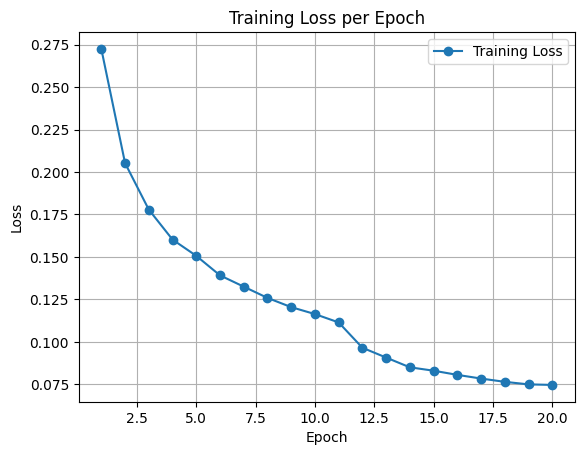

In [180]:
plt.plot(range(1, len(train_losses_NeuMF) + 1), train_losses_NeuMF, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

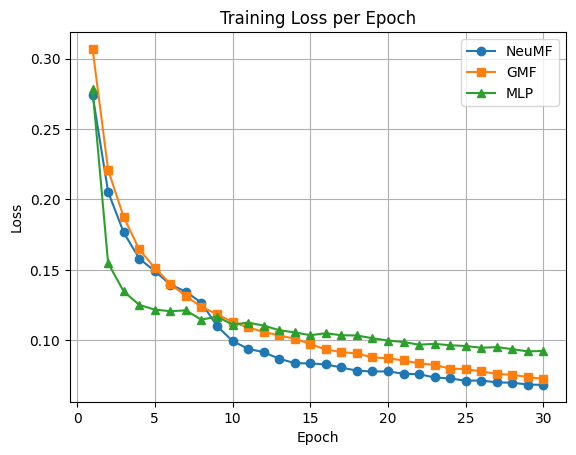

In [172]:

plt.plot(range(1, len(train_losses_NeuMF) + 1), train_losses_NeuMF, marker='o', label='NeuMF')
plt.plot(range(1, len(train_losses_GMF) + 1), train_losses_GMF, marker='s', label='GMF')
plt.plot(range(1, len(train_losses_MLP) + 1), train_losses_MLP, marker='^', label='MLP')

plt.xlabel('Epoch')
plt.ylabel('Giá trị mất mát')
plt.title('Giá trị mất mát trong quá trình huấn luyện')
plt.legend() 
plt.grid(True) 
plt.show()


Xu hướng của giá trị mất mát trong quá trình huấn luyện trong 10 lần huấn luyện đầu tiên đều giảm rõ rệt, sau đó trở về trạng thái ổn định. GMF có tốc độ giảm nhanh từ 1 đến 5 epoch và chậm dần sau 10 epoch. MLP có tốc độ giảm nhanh nhất trong giai đoạn 1 đến 3 epoch, tuy nhiên sau 5 epoch thì giảm chậm lại và có mức hội tụ cao nhất và cũng là mô hình có hiệu suất thấp nhất. NeuMF có giá trị mất mát thấp nhất và đạt hiệu suất cao nhất trong 3 mô hình. 
Tóm lại, NeuMF là mô hình tốt nhất về cả hiệu suất và khả năng tối ưu hóa loss. Điều này cho thấy NeuMF tận dụng tốt ưu điểm khi kết hợp 2 mô hình GMF và MLP và tính hợp lý, đúng đắn và hiệu quả khi dùng BCE trong việc học qua dữ liệu ngầm.


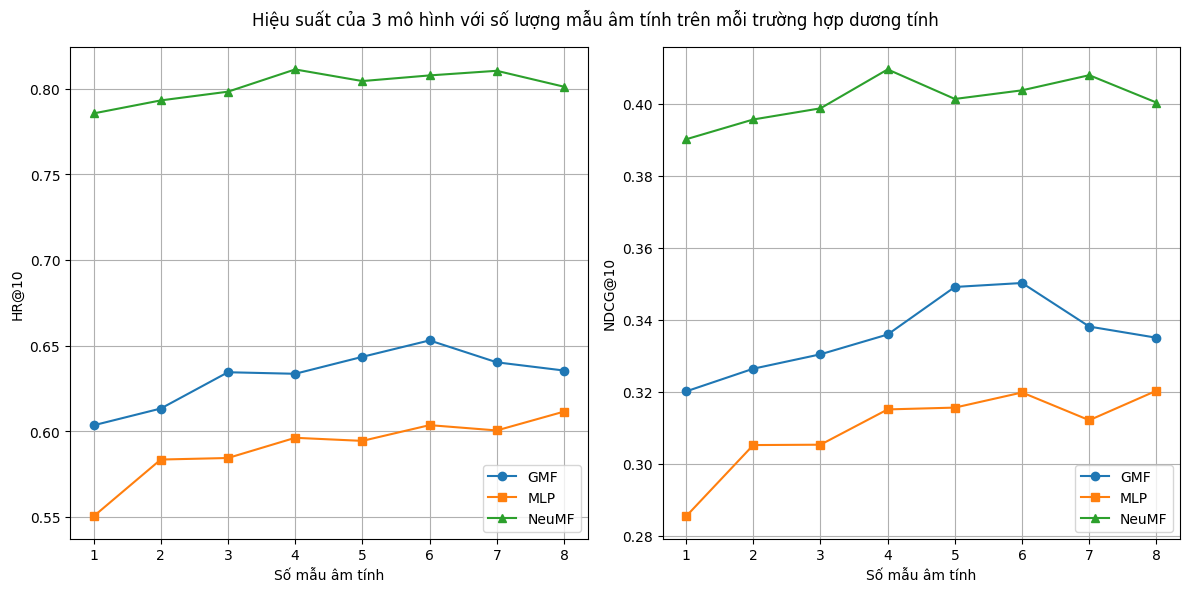

In [30]:
GMF_HR = [0.6034, 0.6132, 0.6344, 0.6335, 0.6434, 0.6530, 0.6402, 0.6354]
MLP_HR = [0.5502, 0.5834, 0.5843, 0.5961, 0.5943, 0.6035, 0.6004, 0.6114]
NeuMF_HR = [0.7856, 0.7932, 0.7983, 0.8113, 0.8045, 0.8078, 0.8105, 0.8012]
x_HR = [1, 2, 3, 4, 5, 6 , 7 , 8]
GMF_NDCG = [0.3201, 0.3264, 0.3304, 0.3359, 0.3491, 0.3502, 0.3381, 0.3350]
MLP_NDCG = [0.2854, 0.3052, 0.3053, 0.3151, 0.3156, 0.3198, 0.3121, 0.3203]
NeuMF_NDCG = [0.3901, 0.3956, 0.3987, 0.4095, 0.4013, 0.4037, 0.4079, 0.4003]
x_NDCG = [1, 2, 3, 4, 5, 6 , 7 , 8]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(x_HR, GMF_HR, marker='o', label='GMF')
ax1.plot(x_HR, MLP_HR, marker='s', label='MLP')
ax1.plot(x_HR, NeuMF_HR, marker='^', label='NeuMF')
ax1.set_xlabel('Số mẫu âm tính')
ax1.set_ylabel('HR@10')
ax1.legend()
ax1.grid()

ax2.plot(x_NDCG, GMF_NDCG, marker='o', label='GMF')
ax2.plot(x_NDCG, MLP_NDCG, marker='s', label='MLP')
ax2.plot(x_NDCG, NeuMF_NDCG, marker='^', label='NeuMF')
ax2.set_xlabel('Số mẫu âm tính')
ax2.set_ylabel('NDCG@10')
ax2.legend()
ax2.grid()
# plt.legend(title='Models', fontsize=10)
plt.suptitle('Hiệu suất của 3 mô hình với số lượng mẫu âm tính trên mỗi trường hợp dương tính')
plt.tight_layout()
plt.show()


Ta thấy rằng việc lấy 1 mẫu dương tính và 1 mẫu âm tính cho kết quả thấp nhất. Tỷ lệ lấy mẫu tối ưu là khoảng từ 3 đến 6. Khi tỷ lệ lấy mẫu lớn hơn 6, hiệu suất của mô hình bắt đầu giảm. Có thể kết luận rằng việc chọn tỷ lệ lấy mẫu quá lớn có thể ảnh hưởng xấu đến hiệu suất của mô hình

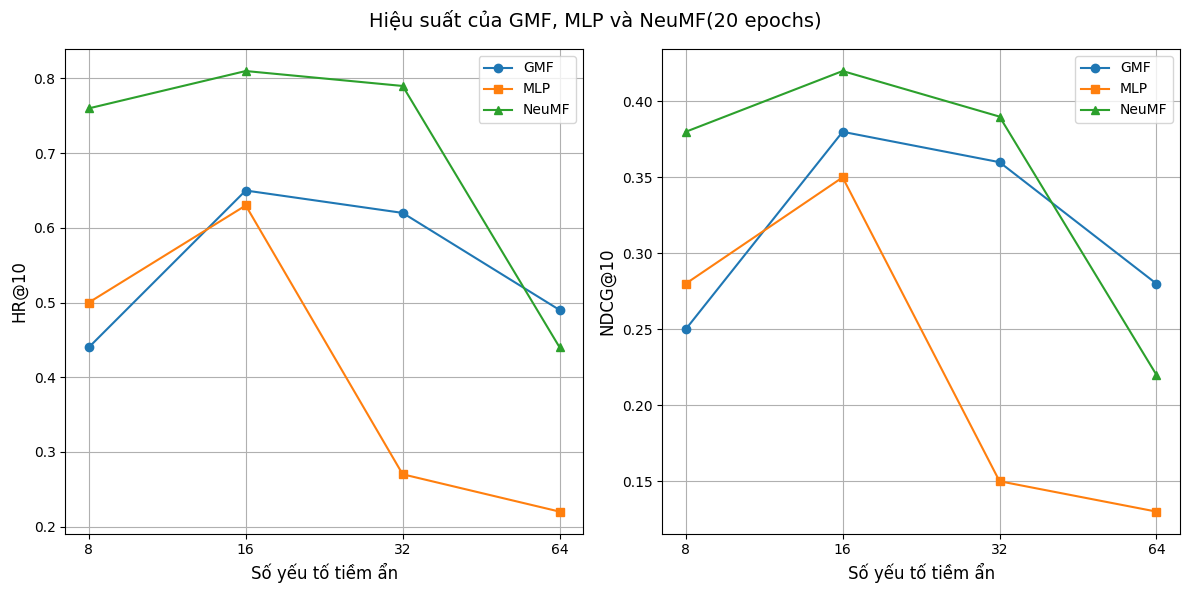

In [38]:
x_HR = ['8', '16', '32', '64']
GMF_HR = [0.44, 0.65, 0.62, 0.49]
MLP_HR = [0.50, 0.63, 0.27, 0.22]
NeuMF_HR = [0.76, 0.81, 0.79, 0.44]

x_NDCG = ['8', '16', '32', '64']
GMF_NDCG = [0.25, 0.38, 0.36, 0.28]
MLP_NDCG = [0.28, 0.35, 0.15, 0.13]
NeuMF_NDCG = [0.38, 0.42, 0.39, 0.22]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(x_HR, GMF_HR, marker='o', label='GMF')
ax1.plot(x_HR, MLP_HR, marker='s', label='MLP')
ax1.plot(x_HR, NeuMF_HR, marker='^', label='NeuMF')
ax1.set_xlabel('Số yếu tố tiềm ẩn', fontsize=12)
ax1.set_ylabel('HR@10', fontsize=12)
ax1.legend()
ax1.grid()

ax2.plot(x_NDCG, GMF_NDCG, marker='o', label='GMF')
ax2.plot(x_NDCG, MLP_NDCG, marker='s', label='MLP')
ax2.plot(x_NDCG, NeuMF_NDCG, marker='^', label='NeuMF')
ax2.set_xlabel('Số yếu tố tiềm ẩn', fontsize=12)
ax2.set_ylabel('NDCG@10', fontsize=12)
ax2.legend()
ax2.grid()

plt.suptitle('Hiệu suất của GMF, MLP và NeuMF(20 epochs)', fontsize=14)
plt.tight_layout()
plt.show()

Mô hình NeuMF có hiệu suất cao nhất trong cả hai chỉ số HR@10 và NDCG@10, đặc biệt ở mức số yếu tố tiềm ẩn là 16 đạt giá trị cao nhất với HR@10(0.81) và NDCG@10(0.42). Tuy nhiên khi số yếu tố tiềm ẩn tăng lên(32 và 64) thì hiệu suất của cả 3 mô hình đều giảm mạnh. Điều này cho thấy mô hình có xu hướng bị overfitting khi tăng số yếu tố tiềm ẩn lên quá cao. 

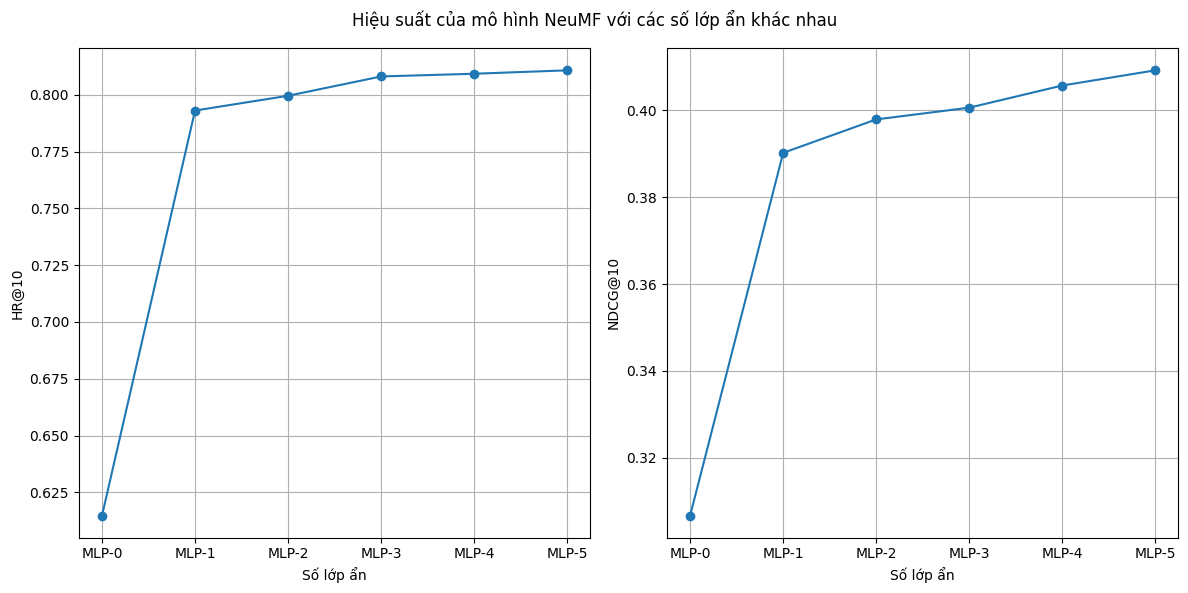

In [35]:
NeuMF_HR = [0.6148, 0.7931, 0.7996, 0.8081, 0.8093, 0.8108]
NeuMF_NDCG = [0.3067, 0.3902, 0.3979, 0.4006, 0.4057, 0.4092]
x_HR = ['MLP-0', 'MLP-1', 'MLP-2', 'MLP-3', 'MLP-4', 'MLP-5']
x_NDCG = ['MLP-0', 'MLP-1', 'MLP-2', 'MLP-3', 'MLP-4', 'MLP-5']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(x_HR, NeuMF_HR, marker='o')
ax1.set_xlabel('Số lớp ẩn')
ax1.set_ylabel('HR@10')
ax1.grid()

ax2.plot(x_NDCG, NeuMF_NDCG, marker='o')
ax2.set_xlabel('Số lớp ẩn')
ax2.set_ylabel('NDCG@10')
ax2.grid()
plt.suptitle('Hiệu suất của mô hình NeuMF với các số lớp ẩn khác nhau')
plt.tight_layout()
plt.show()

Để đánh giá hiệu suất mô hình khi cài đặt các lớp ẩn khác nhau trong mô hình MLP, ta thấy rằng khi mô hình NeuMF không có lớp MLP nào(mô hình tuyến tính) thì mô hình đạt hiệu suất thấp nhất. Điều này chứng tỏ tính phi tuyến của mô hình MLP mang lại là nguyên nhân giúp cải thiện hiệu suất cho mô hình NeuMF. Bên cạnh đó khi tăng dần số lớp ẩn, mô hình cũng cải thiện hiệu suất lên một chút.